# Sprint 機械学習スクラッチ ロジスティック回帰

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, no_bias, verbose, C=1, save=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        self.C = C

        # 保存有無
        self.save = save
        
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        # 訓練データ・学習データのインスタンス変数化
        self.X, self.y, self.X_val, self.y_val, self.theta = self._setting(X, y, X_val, y_val)       
        
        # 重み更新記録用配列
        self.update = np.zeros((self.iter, len(self.theta)))

        for i in range(self.iter):
            self.hypo = self._logistic_hypothesis(self.X)            
            self.grad = self._gradient_descent(self.X, self.y)
            self.update[i] = self.grad
            
            #self.predict_prob = self.predict_proba(self.X)            
            self.loss[i] = self.loss_func(self.y)
            
            if X_val is not None and y_val is not None:
                #self.val_predict_prob = self.predict_proba(self.X_val)
                self.val_loss[i] = self.val_loss_func(self.y_val)
            
            if self.verbose:
                # verboseをTrueにした際は学習過程を出力
                print("iter{}:[loss]:{}".format(i, self.loss[i]))
                print("iter{}:[val_loss]:{}".format(i, self.val_loss[i]))
        
        if self.save:
            np.save("./Update_theta", self.update)
            

    def _setting(self, X, y, X_val, y_val):       
        X_copy = np.copy(X)
        y_copy = np.copy(y)
        
        if X_val is not None and y_val is not None:
            X_val_copy = np.copy(X_val)
            y_val_copy = np.copy(y_val)
                
        if self.no_bias == False:
            X_ones = np.ones(X.shape[0]).reshape(-1, 1)
            X_val_ones = np.ones(X_val.shape[0]).reshape(-1, 1)                
            X_copy = np.hstack((X_ones, X_copy))
            X_val_copy = np.hstack((X_val_ones, X_val_copy))
            np.random.seed(0)
            theta = np.random.randn(X.shape[1] + 1)
            return X_copy, y_copy, X_val_copy, y_val_copy, theta

        else:
            np.random.seed(0)
            theta = np.random.randn(X.shape[1])
            return X_copy, y_copy, X_val_copy, y_val_copy, theta

    # 問題3
    # 推定
    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """ 
        #if self.no_bias == False:
            #X_ones = np.ones(X.shape[0]).reshape(-1, 1)
            #X_copy = np.hstack((X_ones, X))
            
        pred = self.predict_proba(X).round().astype(int)       
        return pred

    # 問題3
    # 推定（確率）
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.no_bias == False:
            X_ones = np.ones(X.shape[0]).reshape(-1, 1)
            X_copy = np.hstack((X_ones, X))

        pred_pro = self._logistic_hypothesis(X_copy)
        return pred_pro
    
    # 問題1
    # シグモイド関数
    def _logistic_hypothesis(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        g = np.dot(X, self.theta.T).reshape(-1, 1)
        hypo = 1/ (1 + np.exp(-g))

        return hypo

    # 問題2
    # 勾配法
    def _gradient_descent(self, X, y, C=1, error=0):
        """
        最急降下法

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        lr：学習率

        C：正則化パラメータ

        Returns
        -------

        """
        m = len(X)

        # バイアス項有
        if self.no_bias == False:
            grad = np.average(np.dot(X.T,(self.hypo - y)), axis=1)
            # 1列目以降のものをλ*theta/mで足す
            delta_theta = grad[1:] + C*self.theta[1:]/(m-1)
            # 0列目と合わせる
            delta_theta = np.hstack([grad[0], delta_theta])

        # バイアス項無
        else:
            grad = np.average(np.dot(X.T,(self.hypo - y)))
            delta_theta = grad + C*self.theta/m
        
        self.theta = self.theta - self.lr*delta_theta
        
        return self.theta

    # 問題4
    # 学習データ損失関数
    def loss_func(self, y):
        """
        損失関数の計算

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples,)
        訓練データまたはテストデータ

        Returns
        ----------
        """
        m = self.X.shape[0]
        loss = np.average((-y*np.log(self.hypo)) - ((1-y)*np.log(1-self.hypo))) + self.C*(self.theta[1:]**2).sum() / 2*m
        
        return loss
    
    # 問題4
    # テストデータ損失関数
    def val_loss_func(self, y):
        """
        損失関数の計算

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples,)
        テストデータ用

        Returns
        ----------
        """
        m = self.X_val.shape[0]
        val_loss = np.average((-y*np.log(self.hypo)) - ((1-y)*np.log(1-self.hypo))) + self.C*(self.theta[1:]**2).sum() / 2*m
        return val_loss
        

## 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。


ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。


g
(
z
)
=
1
1
+
e
−
z
.

線形回帰の仮定関数は次の式でした。


h
θ
(
x
)
=
θ
T
⋅
x
.

まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。


h
θ
(
x
)
=
1
1
+
e
−
θ
T
⋅
x
.

$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


## 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。


θ
j
:=
θ
j
−
α
∂
J
(
θ
)
∂
θ
j
<
b
r
/
>
∂
J
(
θ
)
∂
θ
0
=
1
m
m
∑
i
=
1
 
(
h
θ
(
x
(
i
)
)
−
y
(
i
)
)
x
(
i
)
j
,
j
=
0
<
b
r
/
>
∂
J
(
θ
)
∂
θ
j
=
(
1
m
m
∑
i
=
1
 
(
h
θ
(
x
(
i
)
)
−
y
(
i
)
)
x
(
i
)
j
)
+
λ
m
θ
j
　
,
j
≥
1

$\alpha$ : 学習率


$i$ : サンプルのインデックス


$j$ : 特徴量のインデックス


$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解ラベル


$\theta_j$ : j番目のパラメータ（重み）


$λ$ : 正則化パラメータ

## 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。


仮定関数 $h_\theta(x)$ の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

## 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。


なお、この数式には正則化項が含まれています。


＊数式が見切れる場合、DIVERを全画面にして御覧ください。



In [ ]:
# sklearn
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(X_array, y_array)
lr_pred = lr.predict(X_val)
lr_pred_proba = lr.predict_proba(X_val)

In [ ]:
lr_pred_proba

## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [7]:
from sklearn.datasets import load_iris

#データのダウンロードとXとY変数に代入
iris = load_iris()
df_X = pd.DataFrame(iris.data, columns=iris.feature_names)
df_X.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

df_Y = pd.DataFrame(iris.target)
df_Y.columns = ["Species"]

# データ結合 concat（axis=1）で列に配合
df_0 = pd.concat((df_X, df_Y), axis=1)

# virgicolorとvirginica sepal_lengthとpetal_lengthに再構築する
df = df_0.iloc[50:, :].reset_index()
df = df.drop("index", axis=1)
display(df.head())
display(df.tail())

# 前処理：目的変数【1,2】を【0,1】に置換する
df = df.replace({'Species': {1: 0}})
display(df.head())

df = df.replace({'Species': {2: 1}})
display(df.tail())

,sepal_length,sepal_width,petal_length,petal_width,Species
0,7.0,3.2,4.7,1.4,1
1,6.4,3.2,4.5,1.5,1
2,6.9,3.1,4.9,1.5,1
3,5.5,2.3,4.0,1.3,1
4,6.5,2.8,4.6,1.5,1


,sepal_length,sepal_width,petal_length,petal_width,Species
95,6.7,3.0,5.2,2.3,2
96,6.3,2.5,5.0,1.9,2
97,6.5,3.0,5.2,2.0,2
98,6.2,3.4,5.4,2.3,2
99,5.9,3.0,5.1,1.8,2


,sepal_length,sepal_width,petal_length,petal_width,Species
0,7.0,3.2,4.7,1.4,0
1,6.4,3.2,4.5,1.5,0
2,6.9,3.1,4.9,1.5,0
3,5.5,2.3,4.0,1.3,0
4,6.5,2.8,4.6,1.5,0


,sepal_length,sepal_width,petal_length,petal_width,Species
95,6.7,3.0,5.2,2.3,1
96,6.3,2.5,5.0,1.9,1
97,6.5,3.0,5.2,2.0,1
98,6.2,3.4,5.4,2.3,1
99,5.9,3.0,5.1,1.8,1


In [8]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :4].values
y = df.iloc[:, 4].values

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)

(75, 4)
(25, 4)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)   #後でスケーリングするために使用する平均と標準を計算します。
X_train_scaler = scaler.transform(X_train)   # 標準化　センタリングとスケーリングによって標準化を実行する
X_test_scaler = scaler.transform(X_test)     # 標準化　センタリングとスケーリングによって標準化を実行する

In [10]:
scr_iris = ScratchLogisticRegression(num_iter=1000, 
                                   lr=0.0001,
                                   C=1,
                                   no_bias=False, 
                                   verbose=False,
                                   save=False)

scr_iris.fit(X_train_scaler, y_train, X_test_scaler, y_test)

In [11]:
scr_proba = scr_iris.predict_proba(X_test_scaler)
scr_pred = scr_iris.predict(X_test_scaler)

In [12]:
# sklearn
from sklearn.linear_model import LogisticRegression

sk_iris = LogisticRegression(random_state=0)
sk_iris.fit(X_train_scaler, y_train)
sk_pred = sk_iris.predict(X_test_scaler)
sk_proba = sk_iris.predict_proba(X_test_scaler)

## 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

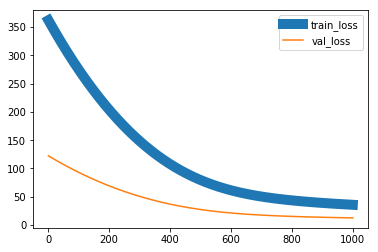

In [13]:
# 損失関数の描画
xlines = np.arange(1, len(scr_iris.loss) + 1)

plt.plot(xlines, scr_iris.loss, linewidth=10, label="train_loss")
plt.plot(xlines, scr_iris.val_loss, label="val_loss")

plt.legend()
plt.show()

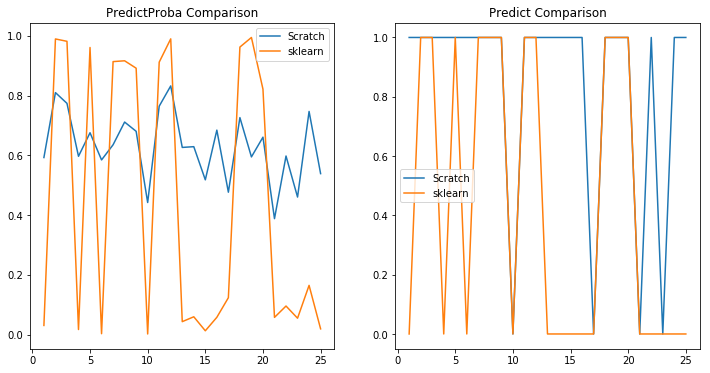

In [17]:
# probaの比較
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

xline = np.arange(1, len(sk_proba) + 1)

axes[0].set_title("PredictProba Comparison")
axes[0].plot(xline, scr_proba, label="Scratch")
axes[0].plot(xline, sk_proba[:, 1], label="sklearn")
axes[0].legend()

axes[1].set_title("Predict Comparison")
axes[1].plot(xline, scr_pred, label="Scratch")
axes[1].plot(xline, sk_pred, label="sklearn")
axes[1].legend()

plt.show()

## 比較すると予測に相違がある。
- 違いは学習率やラムダの違いか？・・・
- 特に確率のところでsklearnのように極値にまでぶれていない感じがある。

## 【問題7】決定領域の可視化
決定領域を可視化してください。

In [18]:
# 特徴量を2つに絞る。
X2 = df.iloc[:, [2, 3]].values
y2 = df.iloc[:, 4].values

X2_train, X2_test, y2_train, y2_test =  train_test_split(X2, y2, test_size=0.25, random_state=1)
print(X2_train.shape)
print(X2_test.shape)

(75, 2)
(25, 2)


In [19]:
scaler.fit(X2_train)   #後でスケーリングするために使用する平均と標準を計算します。
X2_train_scaler = scaler.transform(X2_train)   # 標準化　センタリングとスケーリングによって標準化を実行する
X2_test_scaler = scaler.transform(X2_test)     # 標準化　センタリングとスケーリングによって標準化を実行する

In [20]:
scr_iris2 = ScratchLogisticRegression(num_iter=1000, 
                                   lr=0.0001,
                                   C=1,
                                   no_bias=False, 
                                   verbose=False,
                                   save=False)

scr_iris2.fit(X2_train_scaler, y2_train, X2_test_scaler, y2_test)

In [21]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスタンスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

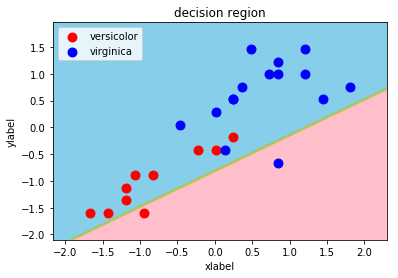

In [22]:
# テストデータ
decision_region(X2_test_scaler, y2_test, scr_iris2)

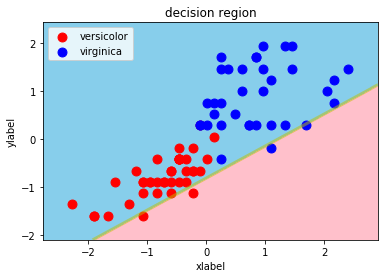

In [24]:
# 訓練データ
decision_region(X2_train_scaler, y2_train, scr_iris2)

## ダメ。

## 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

In [25]:
# np.savezテスト用
scr_lr_iris3 = ScratchLogisticRegression(num_iter=1000, 
                                   lr=0.0001,
                                   C=1,
                                   no_bias=False, 
                                   verbose=False,
                                   save=True)

scr_lr_iris3.fit(X2_train_scaler, y2_train, X2_test_scaler, y2_test)

In [26]:
npz = np.load("./Update_theta.npy")

npz

array([[ 1.76163669,  0.39900526,  0.97754344],
       [ 1.75922216,  0.39785399,  0.97634938],
       [ 1.75680875,  0.3967034 ,  0.9751558 ],
       ...,
       [ 0.2237698 , -0.18226294,  0.27373241],
       [ 0.22310515, -0.18233815,  0.27350438],
       [ 0.22244172, -0.18241288,  0.27327685]])

## class内に組込し、更新されたthetaの保存と読み込みを確認できた。